# Reimagining Public Transport, Post-Covid
## Assignment of ***ST1510:Programming for Data Science*** & ***ST1502:Data Visualisation***

## Background Context:

The COVID-19 pandemic in Singapore is caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), which spreads primarily through droplets generated when an infected person coughs, sneezes or speaks. In response to the growing number of new community cases, Singapore enacted the COVID-19 Control Order, "circuit breaker", which caused a huge impact towards current public transport system and sparks the discussion over the reimagination for the public transport model to cater the change in commute pattern and in preparation for future epidemic spread by airborne transmission.


## Objectives of Study:
1. Visualise Impacts of COVID-19 toward Singapore Public Transport System (Train & LRT, Taxi and Flight).
2. Investigate Solutions to Reimagine Singapore Public Transport System.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
# Requests for APIs and Webpages
import requests
import pytz
# BeautifulSoup to Scrape Table from html
from io import StringIO
from bs4 import BeautifulSoup
# tabula-py to Scrape Table From .pdf files
from tabula import read_pdf
# Folium & Plugins For Map Plotting Library
import folium
from branca.element import Figure
from folium.plugins import HeatMapWithTime

# PDAS : Data Wrangling and Exporting Cleaned Dataset
---
## List of Raw Dataset Used:
### Objective 1: Visualise Impacts of COVID-19 toward Singapore Public Transport System (Train & LRT, Taxi and Flight)
- Train and LRT
    1. https://www.sbstransit.com.sg/ridership
- Taxi
    2. https://www.lta.gov.sg/content/ltagov/en/who_we_are/statistics_and_publications/statistics.html
- Flight
    3. https://data.gov.sg/dataset/civil-aircraft-arrivals-departures-passengers-and-mail-changi-airport-monthly
    4. https://www.changiairport.com/corporate/our-expertise/air-hub/traffic-statistics.html

### Objective 2: Investigate Solutions to Reimagine Singapore Public Transport System
- Rethinking Micromobility: Promote Use of Micromobility devices
    5. https://data.gov.sg/dataset/cycling-path-network
    6. https://data.gov.sg/dataset/hdb-cycling-paths-under-construction
- Change Commuter Patterns: Stagger Work Hour
    7. http://datamall2.mytransport.sg/ltaodataservice/EstTravelTimes (DataMall Dynamic API: [Full Documentation](https://datamall.lta.gov.sg/content/dam/datamall/datasets/LTA_DataMall_API_User_Guide.pdf))
    8. https://developers.onemap.sg/commonapi/search (OneMap API: [Full Documentation](https://docs.onemap.sg/))


# Train and LRT

Infos of Ridership of Trains Operated by SBSTransit *(e.g. North East Line(NEL), Downtown Line(DTL), Sengkang and Punggol Light Rail Transit(LRT))* is scraped from [SBSTransit](https://www.sbstransit.com.sg/ridership) website using `requests` and `BeautifulSoup`

### Querying the HTML Table and Extract the Information to `pandas.DataFrame`

In [23]:
html_soup = BeautifulSoup(requests.get('https://www.sbstransit.com.sg/ridership').text, 'html.parser') #Query HTML page and parse into BeautifulSoup obj
text = ''
for table_row in html_soup.find('table').find_all('tr')[1:]: #Iter over each row in html table
    text += table_row.get_text().replace(',','').replace('\n',',') #Remove comma in value and use comma as delimiter 
    text += '\r\n' #Break into new line
train_df = pd.read_csv(StringIO(text)) #Turn String into DataFrame
train_df

Unnamed: 0      Month    2014    2015    2016     2017     2018     2019  \
0          NaN    January  649460  686426  875831   934363  1142026  1250833   
1          NaN   February  627959  691918  859465   948224  1141750  1186795   
2          NaN      March  637010  688147  880966   955433  1144294  1217877   
3          NaN      April  637727  689305  879413   937046  1149121  1213490   
4          NaN        May  641864  696010  886145   925537  1146071  1201397   
5          NaN       June  654114  695964  882270   919224  1140105  1167470   
6          NaN       July  678218  738130  924305   970856  1222488  1273328   
7          NaN     August  687131  736760  931257   974022  1212155  1238783   
8          NaN  September  684510  713374  931944   949122  1210267  1236770   
9          NaN    October  676531  724470  924299  1010020  1221798  1241812   
10         NaN   November  668592  708426  903336  1102296  1182284  1213402   
11         NaN   December  692202  771239  908271  1079944  1152919  1170724   

       2020    2021    2022  Unnamed: 11  
0   1195131  844322  848905          NaN  
1   1016292  853580                  NaN  
2    923319  882892                  NaN  
3    288664  897317                  NaN  
4    195515  621167                  NaN  
5    421444  569958                  NaN  
6    628983  675404                  NaN  
7    685186  685256                  NaN  
8    735858  729145                  NaN  
9    776078  640011                  NaN  
10   795843  709651                  NaN  
11   850271  819753                  NaN

### Dropping Unwanted Columns

In [24]:
train_df.drop(columns = ['Unnamed: 0', 'Unnamed: 11', '2021', '2014', '2015', '2022'], inplace=True) #Drop Year 2014 to 2015 & 2021 to allow merging
train_df

Month    2016     2017     2018     2019     2020
0     January  875831   934363  1142026  1250833  1195131
1    February  859465   948224  1141750  1186795  1016292
2       March  880966   955433  1144294  1217877   923319
3       April  879413   937046  1149121  1213490   288664
4         May  886145   925537  1146071  1201397   195515
5        June  882270   919224  1140105  1167470   421444
6        July  924305   970856  1222488  1273328   628983
7      August  931257   974022  1212155  1238783   685186
8   September  931944   949122  1210267  1236770   735858
9     October  924299  1010020  1221798  1241812   776078
10   November  903336  1102296  1182284  1213402   795843
11   December  908271  1079944  1152919  1170724   850271

### Unpivoting Table and converting index column to `np.datetime64` format

In [25]:
train_df = train_df.melt(id_vars = 'Month', var_name='year', value_name='SBSTransit Ridership') #Unpivoting the dataframe
train_df.index = train_df[['Month', 'year']].agg(' '.join, axis = 1)#Combining Month and Year column and set it to index
train_df.index = pd.to_datetime(train_df.index, format="%B %Y")#Convert index into datetime format
train_df = train_df[['SBSTransit Ridership']]#Filter the dataframe so only SBSTransit Ridership column is left
train_df.head()

SBSTransit Ridership
2016-01-01                875831
2016-02-01                859465
2016-03-01                880966
2016-04-01                879413
2016-05-01                886145

### DataFrame Inspection

Observations:
> All Columns is having correct datatypes of `int64`

> Null Values is not observed in All Columns

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2016-01-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   SBSTransit Ridership  60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


# Taxi
Infos of Taxis Fleet in Singapore is obtained from [LTA Statistics Taxi Columns](https://www.lta.gov.sg/content/ltagov/en/who_we_are/statistics_and_publications/statistics.html).

The tables is extracted from `.pdf` format into `.csv` format with `tabula-py` converter and manual conversion

In [27]:
taxi_df = pd.read_csv('raw_data/Impact_of_COVID/taxi/taxi_info_2020.csv', index_col=0) #Reading First Dataset
for year in range(2019,2015,-1): #Loop Through Years from 2019 to 2016
    taxi_df_new = pd.read_csv(f'raw_data/Impact_of_COVID/taxi/taxi_info_{year}.csv', index_col=0) #Read Dataset of Next year
    taxi_df = pd.concat([taxi_df, taxi_df_new], axis = 1) #Append the records of dataset into next rows by column
taxi_df = taxi_df.T #Transpose the Dataset
taxi_df.head()

Average daily number of taxi trips(One-Shift)  \
Jan-20                                           16.2   
Feb-20                                           14.4   
Mar-20                                           13.3   
Apr-20                                            8.0   
May-20                                            7.5   

        Average engaged mileage per trip (km)(One-Shift)  \
Jan-20                                              10.5   
Feb-20                                              10.2   
Mar-20                                               9.7   
Apr-20                                               9.3   
May-20                                               9.6   

        Average daily number of taxi trips(Two-Shift)  \
Jan-20                                           24.3   
Feb-20                                           22.3   
Mar-20                                           20.1   
Apr-20                                           11.3   
May-20                                           10.4   

        Average engaged mileage per trip (km)(Two-Shift)  Comfort  CityCab  \
Jan-20                                              10.4   8106.0   2695.0   
Feb-20                                              10.0   8121.0   2702.0   
Mar-20                                               9.8   7988.0   2651.0   
Apr-20                                               9.6   7685.0   2597.0   
May-20                                               9.8   7588.0   2571.0   

        Trans-Cab    SMRT  Premier  Prime   HDTT  Individual Yellow-Top Total  \
Jan-20     2821.0  2462.0   1576.0  672.0  129.0                         67.0   
Feb-20     2711.0  2462.0   1560.0  675.0  129.0                         65.0   
Mar-20     2498.0  2457.0   1524.0  665.0  129.0                         65.0   
Apr-20     2373.0  2454.0   1446.0  665.0  129.0                         65.0   
May-20     2328.0  1698.0   1334.0  665.0  129.0                         65.0   

        No. of TDVL issued  Total No. of valid TDVL holders  
Jan-20               226.0                         101387.0  
Feb-20                90.0                         101409.0  
Mar-20               181.0                         101068.0  
Apr-20                15.0                         100517.0  
May-20               202.0                          99280.0

### DataFrame Inspection

Observations:
> All Columns is having correct datatypes of `float64`

> Null Values is observed for `HDTT` & `No. of TDVL issued` columns

> No Extreme Outliers is observed by comparing `min` and `max` values to `25%` and `75%` respectively

In [28]:
print("***Taxi Dataset Inspection***\n")
taxi_df.info()
taxi_df.describe()

***Taxi Dataset Inspection***

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, Jan-20 to Dec-16
Data columns (total 14 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Average daily number of taxi trips(One-Shift)     59 non-null     float64
 1   Average engaged mileage per trip (km)(One-Shift)  59 non-null     float64
 2   Average daily number of taxi trips(Two-Shift)     59 non-null     float64
 3   Average engaged mileage per trip (km)(Two-Shift)  59 non-null     float64
 4   Comfort                                           59 non-null     float64
 5   CityCab                                           59 non-null     float64
 6   Trans-Cab                                         59 non-null     float64
 7   SMRT                                              59 non-null     float64
 8   Premier                                           59 non-null     f

Average daily number of taxi trips(One-Shift)  \
count                                      59.000000   
mean                                       16.647458   
std                                         2.303547   
min                                         7.500000   
25%                                        16.400000   
50%                                        17.200000   
75%                                        18.000000   
max                                        19.100000   

       Average engaged mileage per trip (km)(One-Shift)  \
count                                         59.000000   
mean                                          10.205085   
std                                            0.352050   
min                                            9.300000   
25%                                           10.000000   
50%                                           10.200000   
75%                                           10.450000   
max                                           10.800000   

       Average daily number of taxi trips(Two-Shift)  \
count                                      59.000000   
mean                                       25.030508   
std                                         3.516035   
min                                        10.400000   
25%                                        25.000000   
50%                                        25.600000   
75%                                        26.750000   
max                                        28.800000   

       Average engaged mileage per trip (km)(Two-Shift)       Comfort  \
count                                         59.000000     59.000000   
mean                                           9.962712   9950.983051   
std                                            0.338301   1879.556032   
min                                            9.300000   7151.000000   
25%                                            9.750000   8318.000000   
50%                                           10.000000   9379.000000   
75%                                           10.200000  11880.000000   
max                                           10.500000  12775.000000   

           CityCab    Trans-Cab         SMRT      Premier       Prime  \
count    59.000000    59.000000    59.000000    59.000000   59.000000   
mean   3392.491525  3594.389831  2708.016949  1808.457627  696.677966   
std     657.611230   823.968300   613.591532   237.682730   41.291412   
min    2400.000000  2314.000000  1697.000000  1291.000000  622.000000   
25%    2817.000000  2961.500000  2298.000000  1673.000000  665.500000   
50%    3244.000000  3560.000000  2462.000000  1907.000000  687.000000   
75%    4075.000000  4549.500000  3386.000000  1985.000000  716.500000   
max    4372.000000  4847.000000  3577.000000  2062.000000  800.000000   

             HDTT  Individual Yellow-Top Total  No. of TDVL issued  \
count   28.000000                    59.000000           58.000000   
mean   119.678571                    89.084746          325.620690   
std     14.178893                    27.764582          236.854521   
min     88.000000                    57.000000           15.000000   
25%    108.250000                    69.000000          169.750000   
50%    129.000000                    81.000000          308.500000   
75%    129.000000                   103.000000          397.250000   
max    129.000000                   154.000000         1367.000000   

       Total No. of valid TDVL holders  
count                        59.000000  
mean                      99159.559322  
std                        1778.879154  
min                       95507.000000  
25%                       97910.500000  
50%                       99587.000000  
75%                      100475.500000  
max                      101659.000000

### Cleaning Null Values
Fill 0 for missing value of `HDTT` & `No. of TDVL issued` 

*(HDTT has been granted a taxi service operator licence starting from 1 Aug 2018)*

In [29]:
print(f"***Before Imputing Null Values***\n{taxi_df.isnull().sum()}")
taxi_df.fillna(0, inplace = True)
print(f"\n***After Imputing Null Values***\n{taxi_df.isnull().sum()}")

***Before Imputing Null Values***
Average daily number of taxi trips(One-Shift)        0
Average engaged mileage per trip (km)(One-Shift)     0
Average daily number of taxi trips(Two-Shift)        0
Average engaged mileage per trip (km)(Two-Shift)     0
Comfort                                              0
CityCab                                              0
Trans-Cab                                            0
SMRT                                                 0
Premier                                              0
Prime                                                0
HDTT                                                31
Individual Yellow-Top Total                          0
No. of TDVL issued                                   1
Total No. of valid TDVL holders                      0
dtype: int64

***After Imputing Null Values***
Average daily number of taxi trips(One-Shift)       0
Average engaged mileage per trip (km)(One-Shift)    0
Average daily number of taxi trips(Two-Sh

### Summing Total Number of Taxi Fleet

In [30]:
taxi_df['Total Taxi Fleet']=taxi_df[['Comfort',
       'CityCab', 'Trans-Cab', 'SMRT', 'Premier', 'Prime', 'HDTT',
       'Individual Yellow-Top Total']].sum(axis =1)

### Converting Index to `np.datetime64` data type 

In [31]:
taxi_df.index = pd.to_datetime(taxi_df.index.str.replace('-',' '), format="%b %y") #Convert Index into Datetime format
taxi_df.index.dtype

dtype('<M8[ns]')

### Dropping Unwanted Columns

In [32]:
taxi_df = taxi_df[['Average daily number of taxi trips(One-Shift)',
       'Average engaged mileage per trip (km)(One-Shift)',
       'Average daily number of taxi trips(Two-Shift)',
       'Average engaged mileage per trip (km)(Two-Shift)']] 
taxi_df.head()

Average daily number of taxi trips(One-Shift)  \
2020-01-01                                           16.2   
2020-02-01                                           14.4   
2020-03-01                                           13.3   
2020-04-01                                            8.0   
2020-05-01                                            7.5   

            Average engaged mileage per trip (km)(One-Shift)  \
2020-01-01                                              10.5   
2020-02-01                                              10.2   
2020-03-01                                               9.7   
2020-04-01                                               9.3   
2020-05-01                                               9.6   

            Average daily number of taxi trips(Two-Shift)  \
2020-01-01                                           24.3   
2020-02-01                                           22.3   
2020-03-01                                           20.1   
2020-04-01                                           11.3   
2020-05-01                                           10.4   

            Average engaged mileage per trip (km)(Two-Shift)  
2020-01-01                                              10.4  
2020-02-01                                              10.0  
2020-03-01                                               9.8  
2020-04-01                                               9.6  
2020-05-01                                               9.8

# Flight

Infos of Plane and Flights is obtained from [Civil Aircraft Arrivals, Departures, Passengers And Mail, Changi Airport, Monthly](https://data.gov.sg/dataset/civil-aircraft-arrivals-departures-passengers-and-mail-changi-airport-monthly) at Data.gov.sg

Additional Data Number of Passengers in 2020 is obtained from [Changi Airport Website](https://www.changiairport.com/corporate/our-expertise/air-hub/traffic-statistics.html)

In [33]:
flight_df = pd.read_csv('raw_data/Impact_of_COVID/flight/civil-aircraft-arrivals-departures-and-passengers-changi-airport-monthly.csv')
flight_df.head()

month                                 level_1   value
0  1980-01  Total Aircraft Arrivals And Departures    6501
1  1980-01                        Total Passengers  566879
2  1980-02  Total Aircraft Arrivals And Departures    6112
3  1980-02                        Total Passengers  552263
4  1980-03  Total Aircraft Arrivals And Departures    6391

### Use `pd.pivot` unstack `flight_df` into Columns by Months format

In [34]:
flight_df = pd.pivot(flight_df, columns='level_1', values='value', index='month')#Unstacking dataset
# Removing Name of Index(month) and Columns(level_1) after pivoting
flight_df.index.name=None
flight_df.columns.name=None
flight_df.head()

Total Aircraft Arrivals And Departures  Total Passengers
1980-01                                  6501.0          566879.0
1980-02                                  6112.0          552263.0
1980-03                                  6391.0          597644.0
1980-04                                  6247.0          561218.0
1980-05                                  6301.0          587003.0

### DataFrame Inspection

Observations:
> All Columns is having correct datatypes of `float64`

> Null Values is observed in `Total Aircraft Arrivals And Departures` Columns

> No Extreme Outliers is observed by comparing `min` and `max` values to `25%` and `75%` respectively

In [35]:
flight_df.info()
flight_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 492 entries, 1980-01 to 2020-12
Data columns (total 2 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Total Aircraft Arrivals And Departures  487 non-null    float64
 1   Total Passengers                        492 non-null    float64
dtypes: float64(2)
memory usage: 11.5+ KB


Total Aircraft Arrivals And Departures  Total Passengers
count                              487.000000      4.920000e+02
mean                             15778.778234      2.446857e+06
std                               8563.536552      1.506263e+06
min                               3865.000000      2.450400e+04
25%                               7463.500000      1.166619e+06
50%                              14161.000000      2.199532e+06
75%                              21144.500000      3.385848e+06
max                              33435.000000      6.414495e+06

### Dropping `Total Aircraft Arrivals and Departures` Columns

In [36]:
flight_df.drop(columns='Total Aircraft Arrivals And Departures', inplace=True)
flight_df.columns

Index(['Total Passengers'], dtype='object')

### Converting Index to `np.datetime64` data type 

In [37]:
flight_df.index = pd.to_datetime(flight_df.index, format="%Y-%m")
flight_df.index.dtype

dtype('<M8[ns]')

### Filter Rows to obtain records starting from year 2016 onwards

In [38]:
flight_df = flight_df.loc[flight_df.index.year>=2016]
flight_df.head()

Total Passengers
2016-01-01         4860156.0
2016-02-01         4602026.0
2016-03-01         4902767.0
2016-04-01         4793662.0
2016-05-01         4781918.0

# Merging Dataset Based on Index

> Null Values is observed After Merging due to missing records, the values is not imputed for accurate visualisation

In [39]:
pub_trans_df = pd.merge(train_df, flight_df, left_index=True, right_index=True, how='outer')
pub_trans_df = pub_trans_df.merge(taxi_df, left_index=True, right_index=True, how='outer')
pub_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2016-01-01 to 2020-12-01
Freq: MS
Data columns (total 6 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   SBSTransit Ridership                              60 non-null     int64  
 1   Total Passengers                                  60 non-null     float64
 2   Average daily number of taxi trips(One-Shift)     59 non-null     float64
 3   Average engaged mileage per trip (km)(One-Shift)  59 non-null     float64
 4   Average daily number of taxi trips(Two-Shift)     59 non-null     float64
 5   Average engaged mileage per trip (km)(Two-Shift)  59 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 3.3 KB



## Checking Outliers

> As most outliers are at the lower bound which is likely due to impact of **COVID-19**, imputing it might lose valuable information for data visualisation. 

> Hence, **no action** is taken to impute the outliers.

C:\Users\amir_\anaconda\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


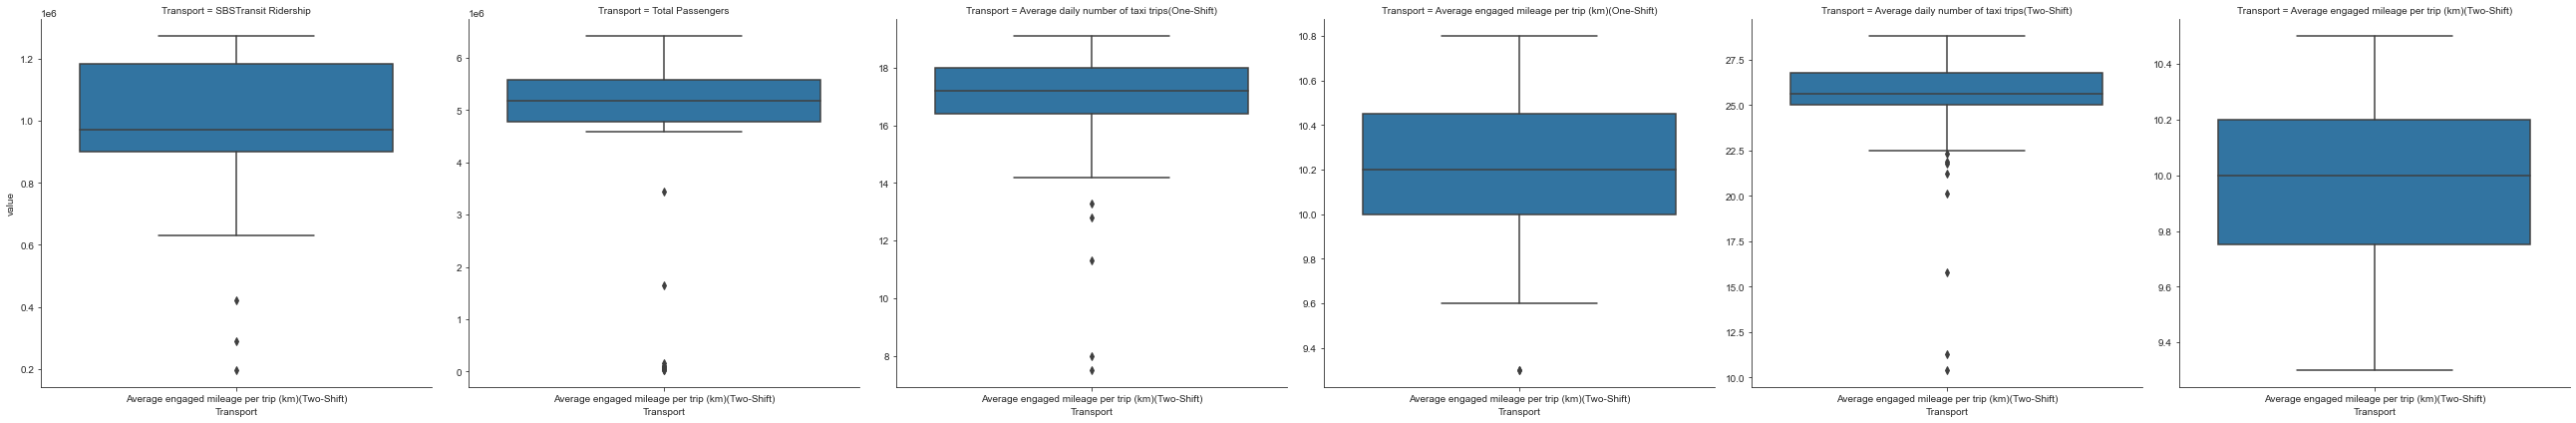

In [40]:
sns.set_style('ticks')
g = sns.FacetGrid(pub_trans_df.melt(var_name='Transport'), col='Transport', sharey=False, height=6)
g.map(sns.boxplot, 'Transport', 'value')
plt.show()

### Exporting `pub_trans_df` to `PublicTransport.csv`  

In [41]:
pub_trans_df.to_csv('cleaned_data/PublicTransport.csv', index_label='Month') 

# Change Commuter Patterns: Stagger Work Hour
![Aws API Query Screenshot](img/AWS_SageMaker_API.png)

> The Notebook Above is Run on AWS SageMaker to Query LTA DataMall [EstTravelTimes](https://datamall.lta.gov.sg/content/dam/datamall/datasets/TrafficRelated/EstTravelTimes.zip) API for 24 Hour with 30 Minutes Interval on a Normal Weekday and Output Is Saved as `raw_data/EstTravelTimes.csv`

In [42]:
eta_df = pd.read_csv('raw_data/EstTravelTime.csv', index_col=0)
eta_df

Name  Direction      FarEndPoint            StartPoint  \
0     AYE          1  TUAS CHECKPOINT   AYE/MCE INTERCHANGE   
1     AYE          1  TUAS CHECKPOINT      TELOK BLANGAH RD   
2     AYE          1  TUAS CHECKPOINT        LOWER DELTA RD   
3     AYE          1  TUAS CHECKPOINT        NORMANTON PARK   
4     AYE          1  TUAS CHECKPOINT  NORTH BUONA VISTA RD   
...   ...        ...              ...                   ...   
8587  TPE          2              PIE    PASIR RIS DRIVE 12   
8588  TPE          2              PIE            ELIAS ROAD   
8589  TPE          2              PIE     PASIR RIS DRIVE 8   
8590  TPE          2              PIE        TAMPINES AVE 7   
8591  TPE          2              PIE            LOYANG AVE   

                  EndPoint  EstTime                  time  
0         TELOK BLANGAH RD        2  01/28/2021, 10:00:00  
1           LOWER DELTA RD        1  01/28/2021, 10:00:00  
2           NORMANTON PARK        4  01/28/2021, 10:00:00  
3     NORTH BUONA VISTA RD        2  01/28/2021, 10:00:00  
4              CLEMENTI RD        2  01/28/2021, 10:00:00  
...                    ...      ...                   ...  
8587            ELIAS ROAD        1  01/29/2021, 09:30:50  
8588     PASIR RIS DRIVE 8        1  01/29/2021, 09:30:50  
8589        TAMPINES AVE 7        2  01/29/2021, 09:30:50  
8590            LOYANG AVE        1  01/29/2021, 09:30:50  
8591   PIE/TPE INTERCHANGE        1  01/29/2021, 09:30:50  

[8592 rows x 7 columns]

### Convert DateTime from UTC to Singapore Timezone (UTC+08:00)

In [43]:
eta_df['time'] = pd.to_datetime(eta_df.time).dt.tz_localize('utc').dt.tz_convert(pytz.timezone('Asia/Singapore')) # Covert DateTime from UTC to Singapore Timezone
eta_df['hour'] = eta_df.time.dt.hour # Creating Hour column

### Query [OneMap API](https://docs.onemap.sg/) To Obtain Longitude and Latitude of Road

> OneMap API is unable to get the Longitude and Latitude for all roads (Interchange between highways), np.nan is use to fill the gap of null values before cleaning

In [44]:
unique_road = eta_df.EndPoint.unique() # Get Unique Endpoint 
unique_road_loc_arr = [] # Array that store the dicts of Longitude and Latitude of Endpoint(Road)

for road in unique_road:
    query_string='https://developers.onemap.sg/commonapi/search?searchVal='+str(road)+'&returnGeom=Y&getAddrDetails=Y&pageNum=1'
    resp = requests.get(query_string) # Query OpenMap API to obtain Longitude and Latitude of Endpoint
    try:
        data=resp.json()
        unique_road_loc_arr.append( # Append Longitude and Latitude Dict to Arr
            dict(
                EndPoint=road, 
                long=data['results'][0]['LONGITUDE'], 
                lat=data['results'][0]['LATITUDE']
                )
            )
    except:
        print ("{} Error".format(road))
        unique_road_loc_arr.append( # Append np.nan when the road is not found
            dict(
                EndPoint=road, 
                long=np.nan, 
                lat=np.nan
                )
            )
        pass

### Converting Datatype of the unique_road_loc_df

In [ ]:
unique_road_loc_df = pd.DataFrame(unique_road_loc_arr)
print("***Before Converting DataType of Long & Lat***\n")
unique_road_loc_df.info()
# Convert Longitude and Latitude From Object to Float
unique_road_loc_df.long = unique_road_loc_df.long.astype(float)
unique_road_loc_df.lat = unique_road_loc_df.lat.astype(float)
print("\n\n***After Converting DataType of Long & Lat***\n")
unique_road_loc_df.info()

***Before Converting DataType of Long & Lat***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   EndPoint  119 non-null    object
 1   long      95 non-null     object
 2   lat       95 non-null     object
dtypes: object(3)
memory usage: 2.9+ KB


***After Converting DataType of Long & Lat***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   EndPoint  119 non-null    object 
 1   long      95 non-null     float64
 2   lat       95 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.9+ KB


### Merging `eta_df`(queried from LTA DataMall) with `unique_road_loc_df`(queried from OneMap)

In [ ]:
eta_loc_df = pd.merge(eta_df, unique_road_loc_df, on='EndPoint', how='left') # Merge Dataframe on EndPoint 
eta_loc_df = eta_loc_df.groupby( # Perform Grouping and Obtain the Mean of EstTime(From 2 Direction and multiple timeframe)
    ['hour','Name','EndPoint'], as_index = False, sort=False # Sort = False to preserve order of EndPoint(For Filling Null with ffill method)
    )[['EstTime','long','lat']].mean().sort_values(['hour','Name']) # Sort according to hour and Name
eta_loc_df.head()

hour Name              EndPoint  EstTime        long       lat
768     0  AYE      TELOK BLANGAH RD      2.0  103.810166  1.270763
769     0  AYE        LOWER DELTA RD      1.5  103.823633  1.279961
770     0  AYE        NORMANTON PARK      3.0  103.792795  1.287235
771     0  AYE  NORTH BUONA VISTA RD      1.5  103.790509  1.307025
772     0  AYE           CLEMENTI RD      1.0  103.778487  1.337007

### Imputing Null Values for Longitude and Latitude with FrontFill Method

In [ ]:
print(f"***Before Imputing Null Values***\n{eta_loc_df.isnull().sum()}")
eta_loc_df.fillna(method='ffill', inplace = True) # FrontFill Null Values for Longitude and Latitude
print(f"\n***After Imputing Null Values***\n{eta_loc_df.isnull().sum()}")

***Before Imputing Null Values***
hour          0
Name          0
EndPoint      0
EstTime       0
long        648
lat         648
dtype: int64

***After Imputing Null Values***
hour        0
Name        0
EndPoint    0
EstTime     0
long        0
lat         0
dtype: int64


### Exporting `eta_loc_df` to `EstimatedTimeArivalLoc.csv`

In [ ]:
eta_loc_df.to_csv('cleaned_data/EstimatedTimeArivalLoc.csv')

# DAVI: Plotting Charts & Providing Insights
---
## List of Cleaned Datasets Used
### Objective 1: Visualize impact of COVID-19 towards Singapore Public Transport System(Trains, Taxis & Flight)
1. `PublicTransport.csv`

### Objective 2: Investigate viable solution to revamp current Public Transport Model
2. `cycling-path-network-geojson.geojson`
3. `hdb-cycling-paths-under-construction-geojson.geojson`
4. `EstimatedTimeArrival.csv`

---

## Data Dictionary of Cleaned Datasets
`PublicTransport.csv`

| Columns | Descriptions | Example | DataType |
| :--- | :--- | :--- | :--- |
| Month | Month and Year of Records | 1/1/2016 ... 1/12/2020 | `datetime64` |
| SBSTransit Ridership | Ridership of Trains and LRTs operated by SBSTransit | 875831 | `int64` |
| Total Passengers | Total Number of Air Passengers in Changi Airport | 4860156 | `float64` | 
| Average daily number of taxi trips(One-Shift) | Daily Average Number of Trips for One-Shift Taxi | 18.9 | `float64` |
| Average daily number of taxi trips(Two-Shift) | Daily Average Number of Trips for Two-Shift Taxi | 28.6 | `float64` | 
| Average engaged mileage per trip (km)(One-Shift) | Average Taxi Mileage per Trip for One-Shift Taxi | 10.1 | `float64` |
| Average engaged mileage per trip (km)(Two-Shift) | Average Taxi Mileage per Trip for Two-Shift Taxi | 9.6 | `float64` |


`EstimatedTimeArrival.csv`

| Columns | Descriptions | Example | DataType |
| :--- | :--- | :--- | :--- |
| hour | Time of query of EST in 24h format | 0,1,2...23 | `int64` | 
| Name | Name of Highway | AYE, BKE ... TPE | `object` |
| EndPoint | Name of Road EndPoint | TELOK BLANGAH RD | `object` |
| EstTime | Estimated Time Arrival towards EndPoint in Minute | 2 | `float64` |
| long | Longitude of EndPoint | 103.810166483177 | `float64` |
| lat | Latitude of EndPoint | 1.27076318192364 | `float64` |

# Objective 1: Visualise Impact of COVID-19 Towards Singapore Public Transport System (Train & LRT, Taxi and Flight)

### Reading Cleaned `pub_trans_df` Dataset

In [ ]:
pub_trans_df = pd.read_csv('cleaned_data/PublicTransport.csv') #Reading Cleaned Dataset
pub_trans_df.Month = pd.to_datetime(pub_trans_df.Month) #Changing the Month Column into datetime dtype
pub_trans_df.head()

Month  SBSTransit Ridership  Total Passengers  \
0 2016-01-01                875831         4860156.0   
1 2016-02-01                859465         4602026.0   
2 2016-03-01                880966         4902767.0   
3 2016-04-01                879413         4793662.0   
4 2016-05-01                886145         4781918.0   

   Average daily number of taxi trips(One-Shift)  \
0                                           18.9   
1                                           18.6   
2                                           19.1   
3                                           19.1   
4                                           18.7   

   Average engaged mileage per trip (km)(One-Shift)  \
0                                              10.1   
1                                              10.4   
2                                              10.2   
3                                              10.2   
4                                              10.2   

   Average daily number of taxi trips(Two-Shift)  \
0                                           28.6   
1                                           28.2   
2                                           28.8   
3                                           28.7   
4                                           28.4   

   Average engaged mileage per trip (km)(Two-Shift)  
0                                               9.6  
1                                               9.9  
2                                               9.8  
3                                               9.7  
4                                               9.9

## 1.1 Impact of COVID-19 Towards Train & LRT
Daily Ridership for Trains and LRTs operated by SBSTransit *( North East Line (NEL), Downtown Line (DTL), Sengkang and Punggol Light Rail Transit (LRT))* is visualized. 

***Observations***
- `81.66%` Drop in Daily Ridership of Train & LRT Operated by SBSTransit from around `1.06(M)` Before COVID-19 to minimum of `0.20(M)` During Peak COVID-19 Period.
- Average Lost in Daily Revenue during Peak COVID-19 period is around `S$ 1325659.52`. (By using Average Distance travelled at Normal Timing of Adult Prices)
- The same trend is observed from Busses and Other Trains Line, whereby daily ridership is reported to dropped 71% and 75% respectively. [CNA Article](https://www.channelnewsasia.com/news/commentary/public-transport-mrt-bus-capacity-breakdown-covid-car-share-13329340)

***Key Insights***
- Trains and LRT is heavily impacted by Covid-19 as it is practically impossible to implement safe distancing and indoor environment increases the risk of cross infection in public transport.
- Commuter can only leave house for very specific reason and businesses and schools are closed and move their activities online which reduces number of daily commuters. [Circuit Breaker Rules](https://www.gov.sg/article/what-you-can-and-cannot-do-during-the-circuit-breaker-period)
- Extra expenses for trains and LRT provider to increase the frequency of sanitization for trains and stations and to deploy more transport ambassador to ensure safe distancing. [LTA NewsRoom](https://www.lta.gov.sg/content/ltagov/en/newsroom/2020/4/news-releases/Elevated_safe_distancing_measures_on_public_transport.html )


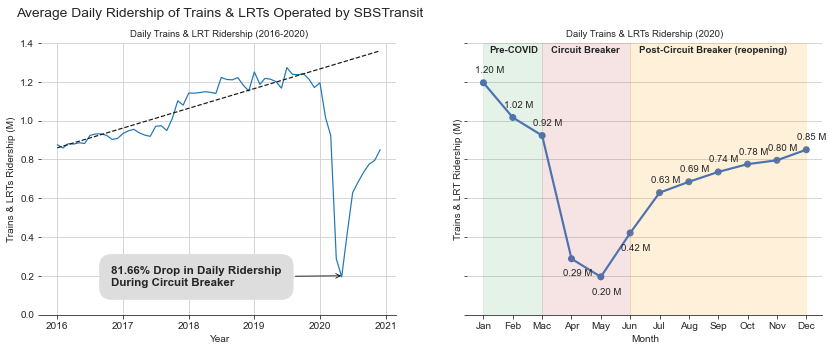

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,5), sharey=True)

sns.set(context="paper", style="white")
sns.lineplot(data = pub_trans_df, x = 'Month', y =pub_trans_df['SBSTransit Ridership']/1e6, ax = ax1)
# Fitting Linear Regression Line
m1, c = np.polyfit(
    mdates.date2num(pub_trans_df[pub_trans_df.Month< '2020-03-01'].Month),
    pub_trans_df[pub_trans_df.Month<'2020-03-01']['SBSTransit Ridership']/1e6,
    deg=1
)
ax1.plot(mdates.date2num(pub_trans_df.Month), c+ m1*mdates.date2num(pub_trans_df.Month), 'k--')
ax1.set_ylabel('Trains & LRTs Ridership (M)')
ax1.set_xlabel("Year")
ax1.grid(True, axis='both')
ax1.annotate(
    "{:.2f}% Drop in Daily Ridership\nDuring Circuit Breaker".format(
        (
            (
                pub_trans_df[pub_trans_df.Month.dt.year <2020]['SBSTransit Ridership'].mean()- 
                pub_trans_df[pub_trans_df.Month.dt.year ==2020]['SBSTransit Ridership'].min()
            )/pub_trans_df[pub_trans_df.Month.dt.year <2020]['SBSTransit Ridership'].mean()
            )*100
        ), 
    xy=(302, 39), 
    xytext=(70, 29), 
    xycoords="axes points", 
    ha="left",
    bbox=dict(boxstyle="round", color='#ddd', pad=1),
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize="large",
    fontweight="demibold"
    )
ax1.set_title("Daily Trains & LRT Ridership (2016-2020)")


data = pub_trans_df[pub_trans_df.Month.dt.year == 2020][['SBSTransit Ridership', 'Month']]
sns.pointplot(data = data, x=data.Month.dt.month, y=data['SBSTransit Ridership']/1e6, ax = ax2)
ax2.set_ylabel("Trains & LRT Ridership (M)")
ax2.set_xticklabels(['Jan','Feb','Mac','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.grid(True, axis='y')

ax2.axvspan(0,2,color='g', alpha=0.15)
ax2.text(0.2 , 1.35, 'Pre-COVID', fontweight="bold", fontsize='medium')
ax2.axvspan(2, 5, color = 'r', alpha = 0.15)
ax2.text(2.3, 1.35, 'Circuit Breaker', fontweight="bold", fontsize='medium')
ax2.axvspan(5, 11, color = 'orange', alpha = 0.15)
ax2.text(5.3, 1.35, 'Post-Circuit Breaker (reopening)', fontweight="bold", fontsize='medium')
for i, txt in enumerate(pub_trans_df[pub_trans_df.Month.dt.year==2020]['SBSTransit Ridership']):
    if i in [3,4,5]:
        ax2.annotate("{:.2f} M".format(txt/1e6), (i-.3, txt/1e6 -.09))
        continue    
    ax2.annotate("{:.2f} M".format(txt/1e6), (i-.3, txt/1e6 +.05))
ax2.set_title("Daily Trains & LRTs Ridership (2020)")
sns.despine(left=True)
plt.ylim(0,1.4)
plt.suptitle('Average Daily Ridership of Trains & LRTs Operated by SBSTransit',x=0.1, horizontalalignment='left', fontfamily='sans-serif', fontsize="x-large")
plt.show()

### Average Lost in Daily Revenue for MRT and LRT operated by SBS Transit during Peak Circuit Breaker Period
From [public-transport-utilisation-average-trip-distance](https://data.gov.sg/dataset/public-transport-utilisation-average-trip-distance), the average trip distance of Trains is around `10.5km` which falls between range of `10.3km - 11.2km`.

From [Fares for MRT and LRT](https://data.gov.sg/dataset/fare-structure-mrts-and-lrts), **adults fare** at **other timings** with travel distance of `10.3km - 11.2km` is `152 cents`

$S\$\text{ Avg Lost in Daily Revenue} = (\text{Ridership}_\text{Before COVID-19}-\text{Ridership}_\text{During Circuit Breaker})*152 \text{ cents}$

In [ ]:
avg_adult_fare = 152/100 #152 Cent For Adult Fare of between range of 10.3km - 11.2km
ridership = pub_trans_df[pub_trans_df.Month < '2020-03-01']['SBSTransit Ridership']
print("Average Lost in Daily Revenue for MRT and LRT operated by SBS Transit during Peak Circuit Breaker Period: \nS$ {:.2f} Daily".format(
    (pub_trans_df[pub_trans_df.Month < '2020-03-01']['SBSTransit Ridership'].mean()
    -pub_trans_df[pub_trans_df.Month >= '2020-03-01']['SBSTransit Ridership'].min()
    )*avg_adult_fare)
)

Average Lost in Daily Revenue for MRT and LRT operated by SBS Transit during Peak Circuit Breaker Period: 
S$ 1325659.52 Daily


## 1.2 Impact of COVID-19 Towards Taxi
Average Daily Number of Taxi Trip and engaged mileage(km) Before COVID-19 and After COVID-19 is visualised.

***Obeservations***
- Average Number of Daily Trips for Taxi driver also face the same dropped of `58.79%` in peak covid period from `16.2, 24.3` trips in Jan to `7.5, 10.4` trips in May.
- Average Mileage shows significant difference as the violin plot does not overlap and p-value of Two-sample independent t-test is  $<\alpha=0.05$.
- Average Lost in Monthly Earning for Single Taxis during Peak COVID-19 Period for One-Shift Taxi and Two-Shift Taxi is `S$ 1668.15` and `S$ 2258.78`.

***Insights***
- Taxi Industry is heavily impacted by COVID-19 as the number of daily trips and average engaged mileage shows a decline likely due to drop in number of commuters.
- Passengers are also skeptical of riding taxi they might assume the driver may contact many passengers in a day and taxis is not sanitized frequently which is prone to cross infection of COVID-19.

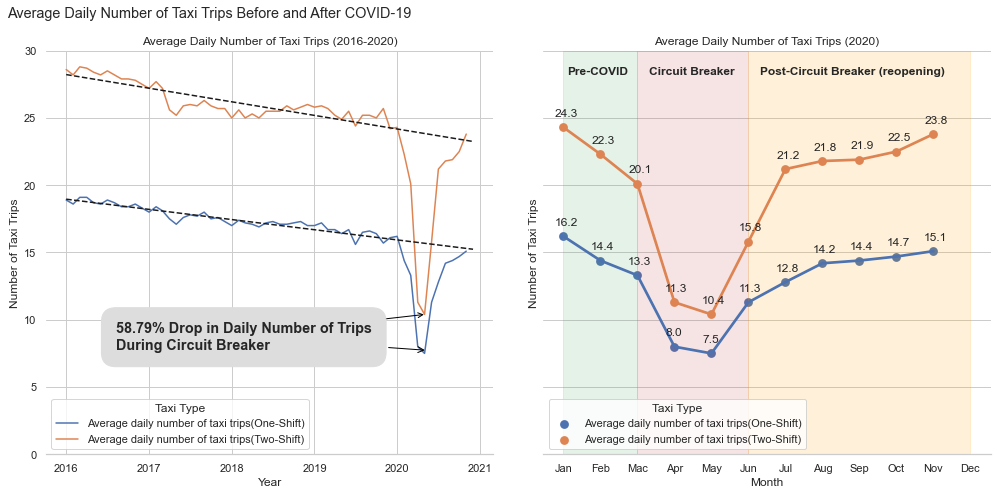

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize = (14,7), sharey=True)
sns.set('notebook',style='whitegrid')
data = pub_trans_df[['Month','Average daily number of taxi trips(One-Shift)', 'Average daily number of taxi trips(Two-Shift)']].melt(id_vars = 'Month', var_name='Taxi Type')
g1 = sns.lineplot(data=data, y='value', x='Month', hue='Taxi Type', ax=ax1)
ax1.set_title('Average Daily Number of Taxi Trips (2016-2020)')
ax1.set_ylabel("Number of Taxi Trips")
ax1.set_xlabel('Year')
m1, c = np.polyfit(
    mdates.date2num(pub_trans_df[pub_trans_df.Month< '2020-03-01'].Month),
    pub_trans_df[pub_trans_df.Month<'2020-03-01']['Average daily number of taxi trips(One-Shift)'],
    deg=1
)
ax1.plot(mdates.date2num(pub_trans_df.Month), c+ m1*mdates.date2num(pub_trans_df.Month), 'k--')
m1, c = np.polyfit(
    mdates.date2num(pub_trans_df[pub_trans_df.Month< '2020-03-01'].Month),
    pub_trans_df[pub_trans_df.Month<'2020-03-01']['Average daily number of taxi trips(Two-Shift)'],
    deg=1
)
ax1.plot(mdates.date2num(pub_trans_df.Month), c+ m1*mdates.date2num(pub_trans_df.Month), 'k--')
ax1.annotate(
    "",
    xy=(380, 140),
    xytext=(70,105),
    xycoords="axes points",
    arrowprops=dict(arrowstyle="->", color="black"),
)
ax1.annotate(
    "{:.2f}% Drop in Daily Number of Trips\nDuring Circuit Breaker".format(
        (
            (
                pub_trans_df[pub_trans_df.Month.dt.year <2020][['Average daily number of taxi trips(One-Shift)', 'Average daily number of taxi trips(Two-Shift)']].mean()- 
                pub_trans_df[pub_trans_df.Month.dt.year ==2020][['Average daily number of taxi trips(One-Shift)', 'Average daily number of taxi trips(Two-Shift)']].min()
            )/pub_trans_df[pub_trans_df.Month.dt.year <2020][['Average daily number of taxi trips(One-Shift)', 'Average daily number of taxi trips(Two-Shift)']].mean()
            ).mean()*100
        ), 
    xy=(381, 104), 
    xytext=(70, 105), 
    xycoords="axes points", 
    ha="left",
    bbox=dict(boxstyle="round", color='#ddd', pad=1),
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize="large",
    fontweight="demibold"
    )


sns.pointplot(data=data[data.Month.dt.year==2020], y='value', x ='Month', hue='Taxi Type', ax=ax2)
for i, (trips_1, trips_2) in enumerate(pub_trans_df[pub_trans_df.Month.dt.year==2020][['Average daily number of taxi trips(One-Shift)', 'Average daily number of taxi trips(Two-Shift)']].values):
    ax2.annotate("{:.1f}".format(trips_1), (i-.25, trips_1 +.8))  
    ax2.annotate("{:.1f}".format(trips_2), (i-.25, trips_2 +.8))
ax2.set_xticklabels(pub_trans_df[pub_trans_df.Month.dt.year==2020].Month.dt.month)
ax2.set_ylabel('Number of Taxi Trips')
ax2.set_title("Average Daily Number of Taxi Trips (2020)")
ax2.set_xticks(np.arange(0,12))
ax2.set_ylim(0,30)
ax2.set_xticklabels(['Jan','Feb','Mac','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.axvspan(0,2,color='g', alpha=0.15)
ax2.text(0.1 , 28.25, 'Pre-COVID', fontweight="bold", fontsize='medium')
ax2.axvspan(2, 5, color = 'r', alpha = 0.15)
ax2.text(2.3, 28.25, 'Circuit Breaker', fontweight="bold", fontsize='medium')
ax2.axvspan(5, 11, color = 'orange', alpha = 0.15)
ax2.text(5.3, 28.25, 'Post-Circuit Breaker (reopening)', fontweight="bold", fontsize='medium')
ax2.legend(title="Taxi Type", loc=3)
plt.suptitle('Average Daily Number of Taxi Trips Before and After COVID-19',x=0.01, horizontalalignment='left', fontfamily='sans-serif')
sns.despine(left=True)
fig.tight_layout()
plt.show()

### Distribution of Average Engaged Mileage per Taxi Trip (km) Before & After COVID-19

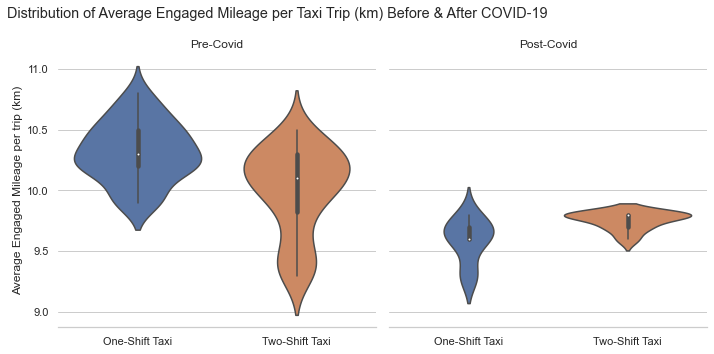

In [ ]:
data = pub_trans_df[['Average engaged mileage per trip (km)(One-Shift)', 'Average engaged mileage per trip (km)(Two-Shift)']]
data['COVID-19']= (pub_trans_df.Month >='2020-03-01').map({True: "Post-Covid", False: "Pre-Covid"})
sns.set_style('whitegrid')
data=data.melt(value_vars=['Average engaged mileage per trip (km)(One-Shift)', 'Average engaged mileage per trip (km)(Two-Shift)'], id_vars='COVID-19')
g = sns.catplot(data=data, x='variable', y='value', col='COVID-19', kind='violin')
g.despine(left=True).set_axis_labels('','Average Engaged Mileage per trip (km)').set_xticklabels(['One-Shift Taxi','Two-Shift Taxi']).set_titles("{col_name}")
plt.suptitle('Distribution of Average Engaged Mileage per Taxi Trip (km) Before & After COVID-19',x=0.01, horizontalalignment='left', fontfamily='sans-serif')
plt.tight_layout()
plt.show()

### Two Sample Independent t-test for Average Mileage of Taxis Before and After COVID-19
Let $\mu_\text{Before COVID}$ be average mileage of Taxis before COVID-19

Let $\mu_\text{After COVID}$ be average mileage of Taxis after COVID-19

$H_0 : \mu_\text{Before COVID} - \mu_\text{After COVID} = 0$

$H_1 : \mu_\text{Before COVID} - \mu_\text{After COVID} \neq 0$

As P-value is < $\alpha = 0.05$, $H_0$ is rejected.

There is significant difference of Average engaged mileage per trip Before and After COVID-19

In [ ]:
x1 = pub_trans_df[pub_trans_df.Month < '2020-03-01']['Average engaged mileage per trip (km)(One-Shift)']
x2 = pub_trans_df[pub_trans_df.Month >= '2020-03-01']['Average engaged mileage per trip (km)(One-Shift)'].dropna()
(t_1, p_val_1, df_1) = sm.stats.ttest_ind(x1, x2, alternative='two-sided', usevar='pooled')
x1 = pub_trans_df[pub_trans_df.Month < '2020-03-01']['Average engaged mileage per trip (km)(Two-Shift)']
x2 = pub_trans_df[pub_trans_df.Month >= '2020-03-01']['Average engaged mileage per trip (km)(Two-Shift)'].dropna()
(t_2, p_val_2, df_2) = sm.stats.ttest_ind(x1, x2, alternative='two-sided', usevar='pooled')
print("Two Sample Independent t-test for Average Mileage Before and After COVID-19")
pd.DataFrame(dict(
    P_Value = [p_val_1, p_val_2],
    Test_Statistic = [t_1, t_2],
    Degree_of_Freedom = [df_1, df_2]
    ), index=["Average Mileage (One-shift)", "Average Mileage (Two-shift)"])

Two Sample Independent t-test for Average Mileage Before and After COVID-19


P_Value  Test_Statistic  Degree_of_Freedom
Average Mileage (One-shift)  8.987793e-12        8.533827               57.0
Average Mileage (Two-shift)  4.498799e-02        2.049866               57.0

### Average Lost in Monthly Earning for Single Taxis during Peak COVID-19 Period

Average Price rate of Normal Taxi is calculated based on following [pricing formula](https://www.taxisingapore.com/taxi-fare/)

$S\$\text{ Avg Price} =  4(\text{Flag-Down Fares}) + \frac{\text{Avg Mileage(km)}}{0.4\text{km}} * 0.22(\text{Fares every 400m}) $

In [ ]:
avg_earning_per_trip = 4 + pub_trans_df[~(pub_trans_df.Month >='2020-03-01')][['Average engaged mileage per trip (km)(One-Shift)', 'Average engaged mileage per trip (km)(Two-Shift)']].mean()/0.4*0.22
avg_earning_per_trip_cb = 4 + pub_trans_df[pub_trans_df.Month >='2020-03-01'][['Average engaged mileage per trip (km)(One-Shift)', 'Average engaged mileage per trip (km)(Two-Shift)']].mean()/0.4*0.22

avg_taxi_earning = pub_trans_df[~(pub_trans_df.Month >='2020-03-01')][['Average daily number of taxi trips(One-Shift)','Average daily number of taxi trips(Two-Shift)']].mean().values*avg_earning_per_trip.values
avg_taxi_earning_cb = pub_trans_df[pub_trans_df.Month >='2020-03-01'][['Average daily number of taxi trips(One-Shift)','Average daily number of taxi trips(Two-Shift)']].mean().values*avg_earning_per_trip_cb.values

print("Average Lost in Monthly Earning for Single Taxis during Peak COVID-19 Period:\nOne-Shift Taxi: S$ {:.2f}\nTwo-Shift Taxi: S$ {:.2f}".format(*((avg_taxi_earning-avg_taxi_earning_cb)*31).tolist()))

Average Lost in Monthly Earning for Single Taxis during Peak COVID-19 Period:
One-Shift Taxi: S$ 1668.15
Two-Shift Taxi: S$ 2258.78


## 1.3 Impact of COVID-19 Towards Flight
Number of Air Passenger Arrival & Departure is visualize.

***Observations***
- Flight industry is impacted the most as Number of air passenger dropped from around `99.5%` from around `5.3 M` Before COVID-19 to merely `24.5 k` in Peak COVID-19 Period
- Despite the lifting of Singapore Circuit Breaker Measures, number of air passengers still remained relatively low despite the common trend of spike in air travel in December from past few years.

***Insights***
- Enclosed and Unventilated environment in a long flight is highly vulnerable to disease spread by airborne transmission including COVID-19 which leads to the decision of international travel restriction that is often carried out by planes. 
- Although the situation of COVID-19 is stabalized in Singapore, the global condition is still highly unstable. Unless the travel restriction is lifted, the number of passengers will not return to Post-Covid period.

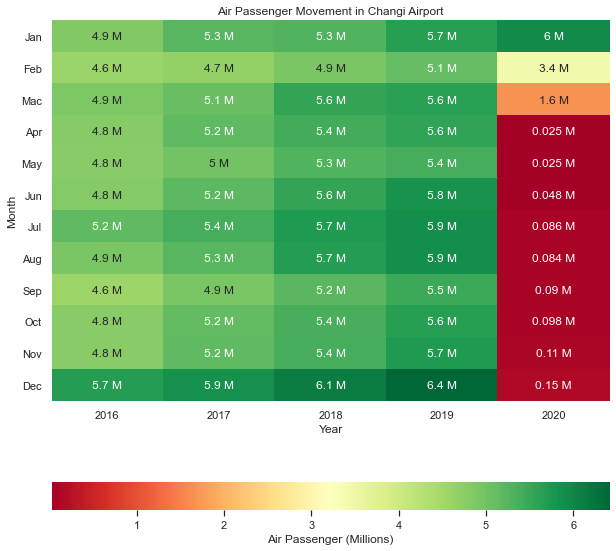

In [ ]:
plt.figure(figsize=(10,10))
data = pd.pivot_table(data = pub_trans_df, index=pub_trans_df.Month.dt.month, columns=pub_trans_df.Month.dt.year, values='Total Passengers')/1e6
data.columns.name = 'Year'
data.index.name = 'Month'
g = sns.heatmap(data, annot=True, cmap='RdYlGn', cbar_kws={'label': 'Air Passenger (Millions)', 'orientation': 'horizontal'})
g.set_yticklabels(['Jan','Feb','Mac','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=0)
for t in g.texts: t.set_text(t.get_text() + " M")
plt.title('Air Passenger Movement in Changi Airport')
plt.show()

# Objective 2: Investigate Solutions to Reimagine Singapore Public Transport System

Current Public Transport Model in Singapore is heavily relied on transport model that is **highly condensed** in an **enclosed environment** for a prolonged period which is perfect for cross-infection of airborne transmitted disease like COVID-19. 

[Research conducted](https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2770172) have shown that COVID-19 is a highly transmissible pathogen in closed environments with air recirculation. 

What are other transport medium that can transport people from one point to another, in a **uncondensed** and **open-air environment**?

## 2.1 Rethinking Micromobility: Promote Use of Micromobility devices
Promote use of Micromobility devices - *bicycles, electric bicycles, and motorised & non-motorised personal mobility devices (PMDs)* for cross-towns and short distance travel to replace the use of busses, trains and taxis.

***Insights***
- Cycling paths in Singapore is very limited with only a few town have dedicated cycle paths which makes cycling unfriendly as cyclist have to either ride on road shoulders to avoid cars, or weave around pedestrians on pedestrian lanes.
- Lack of Cycling path connecting towns disregarding park connectors which is usually far from town centre that makes cycling inconvenience.

***Recommendations***
- Repurposing roads to make it cyclist friendly by dedicating left road lane in town to cyclist and build more cycling lane within and between towns.
- Campaign to promote use of micromobility devices to replace short distance travelling


In [ ]:
fig2=Figure(width=750,height=450)
m_cycle = folium.Map(location=[1.3521, 103.8198],zoom_start=11,min_zoom=10,max_zoom=14)
fig2.add_child(m_cycle)
folium.GeoJson(
    'cleaned_data/cycling-path-network-geojson.geojson', 
    name="geojson", 
    style_function = lambda x:{'fillColor': '#228B22', 'color': '#228B22'},
    tooltip=folium.features.GeoJsonTooltip(['Description'])
    ).add_to(m_cycle)
folium.GeoJson(
    'cleaned_data/hdb-cycling-paths-under-construction-geojson.geojson', 
    name="geojson", 
    style_function = lambda x:{'fillColor': '#FF0000', 'color': '#FF0000'},
    tooltip=folium.features.GeoJsonTooltip(['Description'])
    ).add_to(m_cycle)
m_cycle

## 2.2 Change Commuter Patterns: Stagger Work Hour
For long distance travelling, the public have no choice to rely on public transport but society should change the commuting pattern to make public transport uncondensed and flatten or reduce peak hours.

***Insights***
- From Average Estimated Time Arrival of major highways, we can observe spike in mean ETA in morning(8.00am) and evening(6.00pm) hour.
- From heat bubble map, trend of peak hour can be observe island wide at morning(8.00am) and evening(6.00pm) hour which reflects to the standard working hours of company, results in highly condensed highways and presumably public transports(Trains, LRTs, Busses).

***Recommendations***
- Staggering Working hours in company and digitalising operation of company to flatten the curve of passenger density of public transport.
- Increase the frequency of trains & busses and expansion of train networks to lower the passenger volume of trains & busses.

### Read Cleaned `eta_loc_df` Dataset

In [ ]:
eta_loc_df = pd.read_csv('cleaned_data/EstimatedTimeArivalLoc.csv', index_col=0)
eta_loc_df.head()

hour Name              EndPoint  EstTime        long       lat
768     0  AYE      TELOK BLANGAH RD      2.0  103.810166  1.270763
769     0  AYE        LOWER DELTA RD      1.5  103.823633  1.279961
770     0  AYE        NORMANTON PARK      3.0  103.792795  1.287235
771     0  AYE  NORTH BUONA VISTA RD      1.5  103.790509  1.307025
772     0  AYE           CLEMENTI RD      1.0  103.778487  1.337007

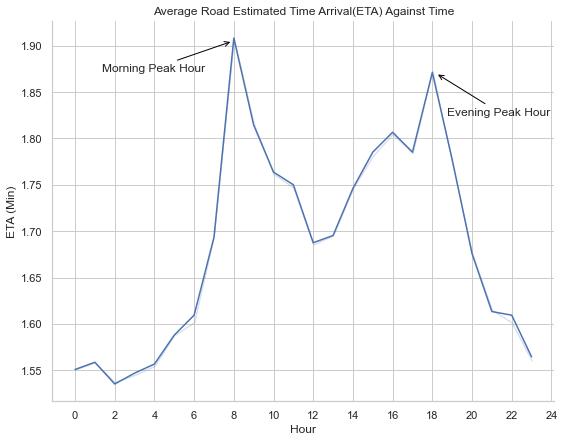

In [ ]:
plt.figure(figsize=(9,7))
sns.set('notebook', 'whitegrid')
sns.lineplot(data = eta_loc_df, x='hour', y='EstTime', estimator='mean', ci=0)
plt.xlabel('Hour')
plt.ylabel('ETA (Min)')
plt.annotate("Morning Peak Hour", xy=(180,360), xytext=(50, 330), xycoords='axes points', arrowprops=dict(arrowstyle="->", color="black"))
plt.annotate("Evening Peak Hour", xy=(18.2,1.87), xytext=(18.75, 1.825), arrowprops=dict(arrowstyle="->", color="black"))
plt.xticks(np.arange(0,26,2))
plt.title('Average Road Estimated Time Arrival(ETA) Against Time')
sns.despine(right = True, top = True)
plt.show()

### Standardization for Estimated Time Arrival 

Standardize Each Endpoint Across 24 Hours to capture the variability of ETA across Endpoints and better Visualise the Congestion across Time with Following Formula:

$$ Est_{standardized} = \frac{Est-\mu_{Est}}{\sigma_{Est}} $$

In [ ]:
heatmap_arr = pd.concat( #ReFormat eta_loc_df into Numpy Array for plotting of HeatMapWithTime 
        [
            eta_loc_df['lat'],
            eta_loc_df['long'],
            eta_loc_df['EstTime']
        ], axis = 1).to_numpy().reshape(24, 128, 3) #Reshape the array into (24(hours), 128(Unique Endpoints), 3(Lattitude, Longitude, EstTime))

heatmap_standardized = heatmap_arr.copy() #copy of heatmap_arr for standardization
heatmap_standardized[:,:,-1] = np.nan_to_num( #Replace Nan(caused by zero division) to zero
    (heatmap_standardized[:,:,-1]-(heatmap_standardized[:,:,-1].mean(axis = 0))) #Perform Standardization for each Unique Endpoint across 24 Hours
    /
    (heatmap_standardized[:,:,-1].std(axis = 0))
)
heatmap_standardized[:,0,-1] #Example of ETATime after standardization

array([ 0.30151134, -3.31662479, -3.31662479,  0.30151134,  0.30151134,
        0.30151134,  0.30151134,  0.30151134,  0.30151134,  0.30151134,
        0.30151134,  0.30151134,  0.30151134,  0.30151134,  0.30151134,
        0.30151134,  0.30151134,  0.30151134,  0.30151134,  0.30151134,
        0.30151134,  0.30151134,  0.30151134,  0.30151134])

In [ ]:
test = (eta_loc_df[eta_loc_df['EndPoint'] == 'TUAS WEST RD']['EstTime'] - eta_loc_df[eta_loc_df['EndPoint'] == 'TUAS WEST RD']['EstTime'].mean())/eta_loc_df[eta_loc_df['EndPoint'] == 'TUAS WEST RD']['EstTime'].std()

In [ ]:
road_congestion_fig=Figure(width=750,height=450)
m_traffic_congestion = folium.Map(location=[1.3521, 103.8198],zoom_start=11,min_zoom=10,max_zoom=14)
road_congestion_fig.add_child(m_traffic_congestion)
HeatMapWithTime(
    heatmap_standardized.tolist(),
    index = ["{}.00 Hour".format(i) if i > 9 else "0{}.00 Hour".format(i) for i in np.arange(0,24) ],
    radius = 10,
    max_opacity=0.8,
    min_opacity=0.5,
    auto_play=False,
    gradient = dict(
        zip(
            np.linspace(0,1,7),
            list(
                map(
                    lambda x : "RGB"+ str(tuple(map(lambda x : int(x*255),x))),
                    list(sns.color_palette('RdYlGn_r',7))
                )
            )
        )
    )
).add_to(m_traffic_congestion)
for endPoint in eta_loc_df.EndPoint.unique():
    folium.CircleMarker(
        location=eta_loc_df[eta_loc_df['EndPoint']==endPoint][['lat','long']].iloc[0].to_list(),
        color = '#ddd',
        radius=10,
        opacity = 0,
        tooltip=endPoint,
        fill=True,
        fillOpacity = 0
    ).add_to(m_traffic_congestion)


m_traffic_congestion


# Conclusion
The **short term heavy impact** towards public transport system clearly indicates its flaw towards epidemic caused by airborne transmission.

Even if COVID-19 is stabalised by current vaccination program in Singapore, [article](https://www.straitstimes.com/world/when-will-life-return-to-normal-in-7-years-at-current-covid-19-vaccination-rates) have shown that it will take at least 7 years before life can turn back to pre-Covid norm on a global scale and the risk of another highly infectious epidemic caused by airborne transmission cannot be neglected.

We should learn from this experience and reimagining current public transport system by -***promoting micromobility*** and ***staggering work hours***- such that impact towards public transport model can be mitigated.

Thank You For Your Reading! 

Last Modified: 12/2/2021